In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

class LitEfficientNet(pl.LightningModule):
    def __init__(self, train_dataloader=None, val_dataloader=None, test_dataloader=None, batch_size=32):
        super(LitEfficientNet, self).__init__()
        self.train_data_loader = train_dataloader
        self.val_data_loader = val_dataloader
        self.test_data_loader = test_dataloader
        self.model = smp.Unet(
            encoder_name="efficientnet-b0", 
            encoder_weights="imagenet", 
            in_channels=3, 
            classes=3
        )
        
        self.batch_size = batch_size
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        losses = {}
        for i in range(3):
            y_i = y[:, i, :, :].float()
            logits_i = logits[:, i, :, :]
            losses[f'class_{i}_loss'] = F.binary_cross_entropy_with_logits(logits_i, y_i)
            self.log(f'class_{i}_loss', losses[f'class_{i}_loss'], on_epoch=True)

        total_loss = sum(losses.values()) / 3
        self.log('loss', total_loss, on_epoch=True)
        return {"loss": total_loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        losses = {}
        for i in range(3):
            y_i = y[:, i, :, :].float()
            logits_i = logits[:, i, :, :]
            losses[f'class_{i}_val_loss'] = F.binary_cross_entropy_with_logits(logits_i, y_i)
            self.log(f'class_{i}_val_loss', losses[f'class_{i}_val_loss'], on_step=True, on_epoch=True, prog_bar=True, logger=True)

        total_loss = sum(losses.values()) / 3
        self.log('val_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'val_loss': total_loss}

    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        losses = {}
        for i in range(3):
            y_i = y[:, i, :, :].float()
            logits_i = logits[:, i, :, :]
            losses[f'class_{i}_val_loss'] = F.binary_cross_entropy_with_logits(logits_i, y_i)
            self.log(f'class_{i}_val_loss', losses[f'class_{i}_val_loss'], on_step=True, on_epoch=True, prog_bar=True, logger=True)

        total_loss = sum(losses.values()) / 3
        self.log('val_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'val_loss': total_loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def train_dataloader(self):
        return self.train_data_loader

    def val_dataloader(self):
        return self.val_data_loader

    def test_dataloader(self):
        return self.test_data_loader


/home/nplab/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/nplab/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [9]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


class SkinDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        
        # Add a filter to exclude directories
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if os.path.isfile(os.path.join(self.image_dir, f))])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if os.path.isfile(os.path.join(self.mask_dir, f))])
        
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        unique_values = np.unique(mask)
        image = self.transform(image)

        mask_np = np.array(mask)
        masks = [(mask_np == val).astype(int) for val in range(3)]
        mask = np.stack(masks, axis=0)
        mask = torch.tensor(mask, dtype=torch.float32)
        return image, mask

transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

train_data = SkinDataset(root_dir='../../../../Datasets/NewSkinDataset/original/val', transform=transform)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

for images, masks in train_loader:
    print(images.shape, masks.shape)
    break


torch.Size([1, 3, 640, 640]) torch.Size([1, 3, 640, 640])


In [10]:
import torch
load_model = torch.load('./model_pt/2023_09_06_init_test.pt')
load_model

LitEfficientNet(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): I

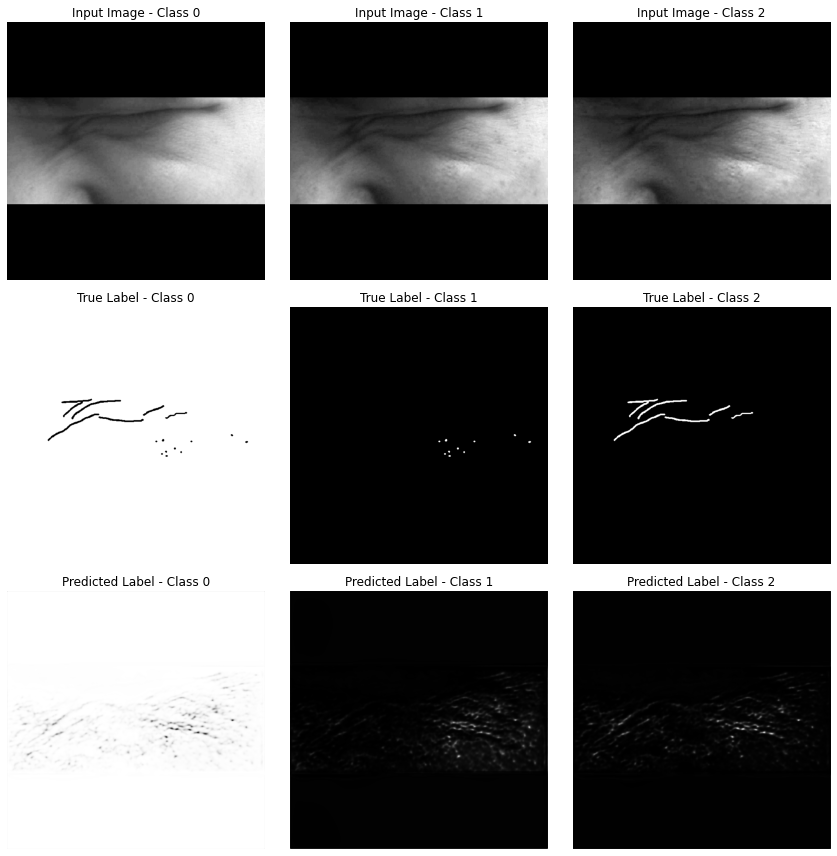

In [11]:
import torch
import matplotlib.pyplot as plt

for batch in train_loader:
    x, y = batch
    logits = load_model(x)

    # 로짓을 확률로 변환
    probs = torch.sigmoid(logits)
    
    # 시각화를 위한 데이터 준비
    to_plot = x.detach().cpu().numpy()
    y_true_plot = y.detach().cpu().numpy()
    y_pred_plot = probs.detach().cpu().numpy()

    # 배치의 첫 번째 이미지만 시각화 (여러 이미지를 시각화하려면 이 부분을 수정)
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))

    for i in range(3):
        axs[0, i].imshow(to_plot[0, i, :, :], cmap='gray')
        axs[0, i].set_title(f'Input Image - Class {i}')
        axs[1, i].imshow(y_true_plot[0, i, :, :], cmap='gray')
        axs[1, i].set_title(f'True Label - Class {i}')
        axs[2, i].imshow(y_pred_plot[0, i, :, :], cmap='gray')
        axs[2, i].set_title(f'Predicted Label - Class {i}')

    # 각 서브플롯의 축을 숨김
    for ax in axs.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    # 더 이상 실행하지 않고 루프 종료 (모든 이미지를 보려면 이 줄을 삭제)
    break


In [24]:
import torch
import pandas as pd
from datasets import load_metric

data = []

for batch in train_loader:
    x, y = batch
    logits = load_model(x)

    probs = torch.sigmoid(logits)

    # 레이블과 예측을 numpy 배열로 변환
    y_true = y.detach().cpu().numpy()
    y_pred = (probs.detach().cpu().numpy() > 0.5).astype(int)  # 확률을 이진 레이블로 변환

    for i in range(3):
        results = load_metric('mean_iou').compute(
            predictions=y_pred[0], 
            references=y_true[0], 
            num_labels=1, 
            ignore_index = 255
        )
    
    break

# 데이터 리스트를 사용하여 DataFrame 생성
df = pd.DataFrame(data, columns=['Class_0_mIoU', 'Class_1_mIoU', 'Class_2_mIoU'])
df


,Class_0_mIoU,Class_1_mIoU,Class_2_mIoU


In [25]:
results = load_metric('mean_iou').compute(
    predictions=y_pred[0][0], 
    references=y_true[0], 
    num_labels=1, 
    ignore_index = 255
)


TypeError: object of type 'numpy.int64' has no len()

In [30]:
y_true.shape

(1, 3, 640, 640)